## Latent Integration Network (LIN)


## Imports

In [ ]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.pnnlDatasets import CCSI_2D

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, convertSimToImage, pkl_save, pkl_load, \
                                    create_1_channel_movie, rel_err

from surrogates4sims.models import Generator, Encoder, ConvDeconvFactor2

from surrogates4sims.train import trainEpoch, validEpoch

import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from glob import glob

## Settings

In [ ]:
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "LIN_from_convDeconv"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "0"#,1,2,3"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
channel = 2
gridsize = 128
dataDirec = '/work/pnnl_liquid_inlet/channel_{}/gridsize_{}'.format(channel,gridsize)
build_vecs = True 
SVDFn = '/work/pnnl_liquid_inlet/channel_1/svd_channel1_gridsize128.pkl'
preprocess = False
AE = True

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = True  
patience = 10

# hyper-params
seed = 1234
np.random.seed(seed)
testSplit = .2
bz = 10
numSamplesToKeep = np.infty #if not debugging
latentDim = 1024
simLen = 500

w = simLen - 1
numComponents = 1024 # this does not include p. so the vectors will be of size numComponents + len(p)
hiddenLayers = [128,128]
hd ='_'.join(map(str,hiddenLayers))
activation = nn.Tanh()

if DEBUG:
    epochs = 2
    numSamplesToKeep = 200
    createDebugData = True
    

versionName = versionName + '_w{}_latentDim{}_hd{}_bz{}_epochs{}'.format(w,numComponents,hd,bz,epochs)
versionName

'LIN_from_convDeconv_GPUs0_w499_latentDim1024_hd128_128_bz10_epochs1000'

## Select Personal GPUs

In [ ]:
!nvidia-smi

Wed Nov 18 13:05:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   18C    P8     8W / 250W |   7180MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   18C    P8     8W / 250W |    947MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN Xp


In [ ]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Wed Nov 18 13:05:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   19C    P2    59W / 250W |   7180MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   18C    P8     8W / 250W |    947MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Load Latent Vectors

In [ ]:
fn = 'convDeconv_latent_vectors_channel{}_gridsize{}.pkl'.format(channel,gridsize)
fn

'convDeconv_latent_vectors_channel2_gridsize128.pkl'

In [ ]:
D = pkl_load(fn)
train_data = D['train']
test_data = D['test']
len(train_data), len(test_data)

(40, 10)

In [ ]:
train_data[0].shape

(500, 1024)

## Investigate how to preprocess the data

In [ ]:
len(train_data), len(test_data)

(40, 10)

In [ ]:
D = []
for d in train_data:
    D.append(d)
D = np.vstack(D)
D.shape

(20000, 1024)

In [ ]:
D.min()

-72.71253

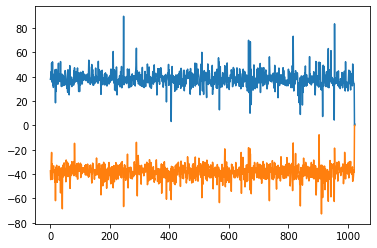

In [ ]:
x_mx = np.max(D,axis=0)
x_mn = np.min(D,axis=0)
plt.plot(x_mx)
plt.plot(x_mn)
plt.show()

In [ ]:
x_mx - x_mn

array([7.520387e+01, 8.405214e+01, 8.291666e+01, ..., 7.283461e+01,
       1.980000e-02, 1.000000e+00], dtype=float32)

## Load inlet velocities

In [ ]:
txtFile = '/data/ccsi/pnnl_liquid_inlet/liquid_inlet_velocity.txt'
with open(txtFile) as fid:
    txt = fid.read().splitlines()
inletVelocity = np.array(list(map(float,txt[1:]))).astype('float32')
inletMx = np.max(inletVelocity)
inletMn = np.min(inletVelocity)
inletVelocity, inletMx, inletMn

(array([0.002  , 0.0021 , 0.00221, 0.00232, 0.00243, 0.00255, 0.00268,
        0.00281, 0.00295, 0.0031 , 0.00326, 0.00342, 0.00359, 0.00377,
        0.00396, 0.00416, 0.00437, 0.00458, 0.00481, 0.00505, 0.00531,
        0.00557, 0.00585, 0.00614, 0.00645, 0.00677, 0.00711, 0.00747,
        0.00784, 0.00823, 0.00864, 0.00908, 0.00953, 0.01   , 0.0105 ,
        0.011  , 0.0116 , 0.0122 , 0.0128 , 0.0134 , 0.0141 , 0.0148 ,
        0.0155 , 0.0163 , 0.0171 , 0.018  , 0.0189 , 0.0198 , 0.0208 ,
        0.0218 ], dtype=float32), 0.0218, 0.002)

In [ ]:
sims = glob(os.path.join(dataDirec,'*.pkl'))
sims = sorted(sims)
numSims = len(sims)
idx = int(testSplit*numSims)
testInds = np.linspace(1,numSims-2,idx).astype('int')
trainInds = list(set(np.arange(0,numSims)).difference(set(testInds)))
print(testInds, trainInds)

[ 1  6 11 16 21 27 32 37 42 48] [0, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 43, 44, 45, 46, 47, 49]


In [ ]:
trainInletVelocities = inletVelocity[trainInds]
testInletVelocities = inletVelocity[testInds]
len(trainInletVelocities),len(testInletVelocities)

(40, 10)

In [ ]:
trainInletVelocities, testInletVelocities

(array([0.002  , 0.00221, 0.00232, 0.00243, 0.00255, 0.00281, 0.00295,
        0.0031 , 0.00326, 0.00359, 0.00377, 0.00396, 0.00416, 0.00458,
        0.00481, 0.00505, 0.00531, 0.00585, 0.00614, 0.00645, 0.00677,
        0.00711, 0.00784, 0.00823, 0.00864, 0.00908, 0.01   , 0.0105 ,
        0.011  , 0.0116 , 0.0128 , 0.0134 , 0.0141 , 0.0148 , 0.0163 ,
        0.0171 , 0.018  , 0.0189 , 0.0198 , 0.0218 ], dtype=float32),
 array([0.0021 , 0.00268, 0.00342, 0.00437, 0.00557, 0.00747, 0.00953,
        0.0122 , 0.0155 , 0.0208 ], dtype=float32))

## Dataset and Dataloader

In [ ]:
class LatentVectors(Dataset):
    def __init__(self, data,inletVelocities,doPreprocess=True,simLen=simLen,mx=x_mx,mn=x_mn):
        self.data = data
        self.doPreprocess = True
        self.simLen = simLen
        self.mx = mx
        self.mn = mn
        self.inletVelocities = inletVelocities
        assert len(inletVelocities) == len(data)
                 
    def __len__(self):
        return len(self.data)

    def preprocess(self,x):
        xnew = 2*((x-self.mn)/(self.mx-self.mn) - .5)
        return xnew

    def invPreprocess(self,xnew):
        x = ((xnew/2)+.5)*(self.mx-self.mn) + self.mn
        return x
    
    def __getitem__(self, idx):
        x = self.data[idx]
        v = self.inletVelocities[idx]
        if self.doPreprocess:
            x = self.preprocess(x)
        xx = np.hstack((x[0],v))
        return xx.reshape(1,len(xx)), x[1:].reshape(self.simLen-1,x.shape[1])

In [ ]:
trainDataset = LatentVectors(train_data, trainInletVelocities ,doPreprocess=True,simLen=simLen,mx=x_mx,mn=x_mn)
#trainDataset = LatentVectors(train_data, testInletVelocities ,doPreprocess=True,simLen=simLen,mx=x_mx,mn=x_mn)
testDataset = LatentVectors(test_data, testInletVelocities,doPreprocess=True,simLen=simLen,mx=x_mx,mn=x_mn)

In [ ]:
X,Y = trainDataset[4]
X.shape,Y.shape

((1, 1025), (499, 1024))

In [ ]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz)
len(trainDataset), len(trainDataLoader), len(testDataset), len(testDataLoader)

(40, 4, 10, 1)

In [ ]:
X,y = next(iter(trainDataLoader))
X.shape, y.shape

(torch.Size([10, 1, 1025]), torch.Size([10, 499, 1024]))

## Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, X,Y, hiddenLayerSizes = [1024], activation=nn.ELU()):
        super(MLP,self).__init__()
        
        self.activation = activation
        self.inputSize = X.shape[1:]
        self.outputSize = Y.shape[1:]
        self.modules = []
        self.modules.append(nn.Linear(np.prod(self.inputSize),hiddenLayerSizes[0]))
        self.modules.append(self.activation)
        for idx,sz in enumerate(hiddenLayerSizes[:-1]):
            self.modules.append(nn.Linear(hiddenLayerSizes[idx],hiddenLayerSizes[idx+1]))
            self.modules.append(self.activation)
                               
        self.modules.append(nn.Linear(hiddenLayerSizes[-1],np.prod(self.outputSize)))
        self.layers = nn.Sequential(*self.modules)
                                
        
    def forward(self,x):
        x = self.layers(x)
        sz = [x.shape[0],*self.outputSize]
        x = x.view(*sz)
        return x

In [ ]:
model = MLP(X,y,hiddenLayerSizes=hiddenLayers,activation=activation)
model

MLP(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=1025, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=510976, bias=True)
  )
)

In [ ]:
y.shape

torch.Size([10, 499, 1024])

In [ ]:
output = model(X)
output.shape

torch.Size([10, 499, 1024])

In [ ]:
if len(gpu_ids.split(',')) > 1:
    model = nn.DataParallel(model)

In [ ]:
printNumModelParams(model)

6 layers require gradients (unfrozen) out of 6 layers
66,063,744 parameters require gradients (unfrozen) out of 66,063,744 parameters


## Loss Function

In [ ]:
L = nn.MSELoss()

In [ ]:
L(output,y)

tensor(0.0609, grad_fn=<MseLossBackward>)

## Set LR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



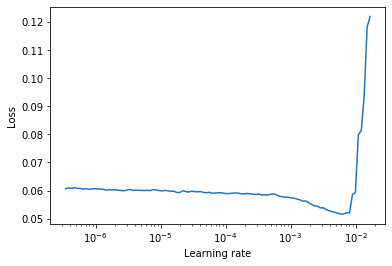

In [ ]:
if findLRs and (len(gpu_ids.split(','))==1): # doesn't work for multigpu???
    opt = create_opt(1e-7,model)
    find_lr(model,opt,L,device,trainDataLoader)


In [ ]:
max_lr = .005
opt = torch.optim.Adam(model.parameters(),lr=max_lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=patience)

## Train

In [ ]:
def trainEpoch(myDataLoader, tensorboard_writer, model, opt, loss,
               metric, lr_scheduler, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    total_loss = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        combined_loss = 0.
        
        # gpu
        X,y = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        y = y.to(device)
        
        # zero the parameter gradients
        opt.zero_grad()

        y_hat = model(X)
        combined_loss = loss(y_hat,y)
        combined_loss.backward()
        opt.step()
        
        # loss
        batch_loss = combined_loss.item()
        running_loss += batch_loss
        total_loss += batch_loss

        # --- Metrics Recording ---

        # metrics
        r = metric(y_hat, y)
        running_rmse += r

        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="LR", scalar_value=opt.param_groups[0]['lr'], global_step=total_steps)

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0

    return total_loss/len(myDataLoader), tensorboard_recorder_step, total_steps


In [ ]:
def validEpoch(myDataLoader, tensorboard_writer, model, loss, metric,
               device, tensorboard_recorder_step):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        combined_loss = 0.
        # --- Metrics Recording ---

        # gpu
        X,y = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        y = y.to(device)
        
        # forward, no gradient calculations
        with torch.no_grad():
            y_hat = model(X)
            combined_loss += loss(y_hat,y)

        running_loss += combined_loss.item()

        # metrics
        r = metric(y_hat, y)
        running_rmse += r

    avg_running_loss = running_loss/len(myDataLoader)
    avg_running_rmse = running_rmse/len(myDataLoader)
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)

    return avg_running_loss

In [ ]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")

checkpoints directory already exists :)


In [ ]:
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

In [ ]:
model = model.to(device)
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty

for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times
    
    writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)
    
    model.train()
    trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                   train_writer, model, opt, L,
                                                                   rmse, lr_scheduler, 
                                                                   tensorboard_rate, device,
                                                                   tensorboard_recorder_step, total_steps)
    
    writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
    writeMessage("LR: {:.4e}".format(opt.param_groups[0]['lr']),versionName)
#     if trainLoss < bestLoss:
#         bestLoss = trainLoss
#         writeMessage("Better trainLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
#         torch.save(model.state_dict(), os.path.join(cps,versionName))
        
    model.eval()
    valLoss = validEpoch(testDataLoader, test_writer, model, L, rmse, device, tensorboard_recorder_step)
    writeMessage("valLoss: {:.4e}".format(valLoss),versionName)

    #checkpoint progress
    if valLoss < bestLoss:
        bestLoss = valLoss
        writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
        torch.save(model.state_dict(), os.path.join(cps,versionName))

    #lr_scheduler.step(trainLoss)
    lr_scheduler.step(valLoss)
    
    if opt.param_groups[0]['lr'] < 5e-8:
        break
writeMessage('---------- Finished Training ----------', versionName)

  0%|          | 0/1000 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/1000 ---
trainLoss: 7.1370e-02
LR: 5.0000e-03
valLoss: 5.2695e-02
Better valLoss: 5.2695e-02, Saving models...


  0%|          | 1/1000 [00:01<30:03,  1.81s/it]

--- Epoch 2/1000 ---
trainLoss: 5.2538e-02
LR: 5.0000e-03
valLoss: 4.4967e-02
Better valLoss: 4.4967e-02, Saving models...


  0%|          | 2/1000 [00:04<35:32,  2.14s/it]

--- Epoch 3/1000 ---
trainLoss: 5.0827e-02
LR: 5.0000e-03


  0%|          | 3/1000 [00:04<25:58,  1.56s/it]

valLoss: 5.6728e-02
--- Epoch 4/1000 ---
trainLoss: 5.2630e-02
LR: 5.0000e-03
valLoss: 4.3945e-02
Better valLoss: 4.3945e-02, Saving models...


  0%|          | 4/1000 [00:07<30:06,  1.81s/it]

--- Epoch 5/1000 ---
trainLoss: 4.7540e-02
LR: 5.0000e-03
valLoss: 4.3271e-02
Better valLoss: 4.3271e-02, Saving models...


  0%|          | 5/1000 [00:10<38:50,  2.34s/it]

--- Epoch 6/1000 ---
trainLoss: 4.6657e-02
LR: 5.0000e-03
valLoss: 4.2036e-02
Better valLoss: 4.2036e-02, Saving models...


  1%|          | 6/1000 [00:14<44:10,  2.67s/it]

--- Epoch 7/1000 ---
trainLoss: 4.6382e-02
LR: 5.0000e-03


  1%|          | 7/1000 [00:14<32:05,  1.94s/it]

valLoss: 4.2264e-02
--- Epoch 8/1000 ---
trainLoss: 4.5287e-02
LR: 5.0000e-03
valLoss: 4.1245e-02
Better valLoss: 4.1245e-02, Saving models...


  1%|          | 8/1000 [00:18<39:46,  2.41s/it]

--- Epoch 9/1000 ---
trainLoss: 4.4107e-02
LR: 5.0000e-03
valLoss: 4.0709e-02
Better valLoss: 4.0709e-02, Saving models...


  1%|          | 9/1000 [00:21<45:43,  2.77s/it]

--- Epoch 10/1000 ---
trainLoss: 4.3632e-02
LR: 5.0000e-03
valLoss: 4.0574e-02
Better valLoss: 4.0574e-02, Saving models...


  1%|          | 10/1000 [00:24<45:07,  2.73s/it]

--- Epoch 11/1000 ---
trainLoss: 4.3083e-02
LR: 5.0000e-03
valLoss: 4.0042e-02
Better valLoss: 4.0042e-02, Saving models...


  1%|          | 11/1000 [00:26<41:24,  2.51s/it]

--- Epoch 12/1000 ---
trainLoss: 4.1788e-02
LR: 5.0000e-03


  1%|          | 12/1000 [00:26<30:01,  1.82s/it]

valLoss: 4.0168e-02
--- Epoch 13/1000 ---
trainLoss: 4.1606e-02
LR: 5.0000e-03


  1%|▏         | 13/1000 [00:26<22:09,  1.35s/it]

valLoss: 4.4139e-02
--- Epoch 14/1000 ---
trainLoss: 4.4734e-02
LR: 5.0000e-03


  1%|▏         | 14/1000 [00:27<16:35,  1.01s/it]

valLoss: 4.0980e-02
--- Epoch 15/1000 ---
trainLoss: 4.1961e-02
LR: 5.0000e-03
valLoss: 3.9715e-02
Better valLoss: 3.9715e-02, Saving models...


  2%|▏         | 15/1000 [00:29<24:14,  1.48s/it]

--- Epoch 16/1000 ---
trainLoss: 4.1598e-02
LR: 5.0000e-03


  2%|▏         | 16/1000 [00:29<18:08,  1.11s/it]

valLoss: 3.9956e-02
--- Epoch 17/1000 ---
trainLoss: 4.1630e-02
LR: 5.0000e-03
valLoss: 3.9575e-02
Better valLoss: 3.9575e-02, Saving models...


  2%|▏         | 17/1000 [00:32<24:19,  1.48s/it]

--- Epoch 18/1000 ---
trainLoss: 4.1130e-02
LR: 5.0000e-03


  2%|▏         | 18/1000 [00:32<18:10,  1.11s/it]

valLoss: 3.9996e-02
--- Epoch 19/1000 ---
trainLoss: 4.0934e-02
LR: 5.0000e-03


  2%|▏         | 19/1000 [00:32<13:43,  1.19it/s]

valLoss: 3.9791e-02
--- Epoch 20/1000 ---
trainLoss: 4.0798e-02
LR: 5.0000e-03


  2%|▏         | 20/1000 [00:32<10:38,  1.54it/s]

valLoss: 3.9789e-02
--- Epoch 21/1000 ---
trainLoss: 4.0659e-02
LR: 5.0000e-03


  2%|▏         | 21/1000 [00:33<08:29,  1.92it/s]

valLoss: 3.9592e-02
--- Epoch 22/1000 ---
trainLoss: 4.0634e-02
LR: 5.0000e-03
valLoss: 3.9521e-02
Better valLoss: 3.9521e-02, Saving models...


  2%|▏         | 22/1000 [00:34<14:25,  1.13it/s]

--- Epoch 23/1000 ---


  2%|▏         | 23/1000 [00:35<11:28,  1.42it/s]

trainLoss: 4.0745e-02
LR: 5.0000e-03
valLoss: 3.9922e-02
--- Epoch 24/1000 ---


  2%|▏         | 24/1000 [00:35<09:07,  1.78it/s]

trainLoss: 4.0674e-02
LR: 5.0000e-03
valLoss: 3.9588e-02
--- Epoch 25/1000 ---


  2%|▎         | 25/1000 [00:35<07:28,  2.17it/s]

trainLoss: 4.0684e-02
LR: 5.0000e-03
valLoss: 3.9577e-02
--- Epoch 26/1000 ---


  3%|▎         | 26/1000 [00:35<06:16,  2.59it/s]

trainLoss: 4.0736e-02
LR: 5.0000e-03
valLoss: 3.9628e-02
--- Epoch 27/1000 ---


  3%|▎         | 27/1000 [00:35<05:29,  2.96it/s]

trainLoss: 4.0656e-02
LR: 5.0000e-03
valLoss: 3.9597e-02
--- Epoch 28/1000 ---


  3%|▎         | 28/1000 [00:36<05:03,  3.20it/s]

trainLoss: 4.0540e-02
LR: 5.0000e-03
valLoss: 3.9617e-02
--- Epoch 29/1000 ---


  3%|▎         | 29/1000 [00:36<04:42,  3.44it/s]

trainLoss: 4.0453e-02
LR: 5.0000e-03
valLoss: 3.9546e-02
--- Epoch 30/1000 ---
trainLoss: 4.0502e-02
LR: 5.0000e-03
valLoss: 3.9429e-02
Better valLoss: 3.9429e-02, Saving models...


  3%|▎         | 30/1000 [00:38<13:00,  1.24it/s]

--- Epoch 31/1000 ---
trainLoss: 4.0607e-02
LR: 5.0000e-03


  3%|▎         | 31/1000 [00:38<10:16,  1.57it/s]

valLoss: 3.9505e-02
--- Epoch 32/1000 ---
trainLoss: 4.0807e-02
LR: 5.0000e-03


  3%|▎         | 32/1000 [00:38<08:13,  1.96it/s]

valLoss: 3.9769e-02
--- Epoch 33/1000 ---
trainLoss: 4.0741e-02
LR: 5.0000e-03


  3%|▎         | 33/1000 [00:39<06:45,  2.38it/s]

valLoss: 3.9747e-02
--- Epoch 34/1000 ---
trainLoss: 4.1032e-02
LR: 5.0000e-03


  3%|▎         | 34/1000 [00:39<05:43,  2.81it/s]

valLoss: 4.0143e-02
--- Epoch 35/1000 ---
trainLoss: 4.0990e-02
LR: 5.0000e-03
valLoss: 3.9428e-02
Better valLoss: 3.9428e-02, Saving models...


  4%|▎         | 35/1000 [00:41<12:25,  1.30it/s]

--- Epoch 36/1000 ---
trainLoss: 4.0973e-02
LR: 5.0000e-03


  4%|▎         | 36/1000 [00:41<09:51,  1.63it/s]

valLoss: 3.9468e-02
--- Epoch 37/1000 ---
trainLoss: 4.1113e-02
LR: 5.0000e-03
valLoss: 3.9398e-02
Better valLoss: 3.9398e-02, Saving models...


  4%|▎         | 37/1000 [00:44<22:18,  1.39s/it]

--- Epoch 38/1000 ---


  4%|▍         | 38/1000 [00:44<16:54,  1.05s/it]

trainLoss: 4.0833e-02
LR: 5.0000e-03
valLoss: 3.9643e-02
--- Epoch 39/1000 ---


  4%|▍         | 39/1000 [00:45<13:00,  1.23it/s]

trainLoss: 4.0653e-02
LR: 5.0000e-03
valLoss: 3.9511e-02
--- Epoch 40/1000 ---


  4%|▍         | 40/1000 [00:45<10:12,  1.57it/s]

trainLoss: 4.0505e-02
LR: 5.0000e-03
valLoss: 3.9548e-02
--- Epoch 41/1000 ---


  4%|▍         | 41/1000 [00:45<08:12,  1.95it/s]

trainLoss: 4.0560e-02
LR: 5.0000e-03
valLoss: 3.9701e-02
--- Epoch 42/1000 ---


  4%|▍         | 42/1000 [00:45<06:45,  2.36it/s]

trainLoss: 4.0626e-02
LR: 5.0000e-03
valLoss: 3.9789e-02
--- Epoch 43/1000 ---


  4%|▍         | 43/1000 [00:45<05:44,  2.78it/s]

trainLoss: 4.0610e-02
LR: 5.0000e-03
valLoss: 3.9516e-02
--- Epoch 44/1000 ---


  4%|▍         | 44/1000 [00:46<05:02,  3.16it/s]

trainLoss: 4.0691e-02
LR: 5.0000e-03
valLoss: 3.9938e-02
--- Epoch 45/1000 ---


  4%|▍         | 45/1000 [00:46<04:39,  3.41it/s]

trainLoss: 4.0669e-02
LR: 5.0000e-03
valLoss: 3.9433e-02
--- Epoch 46/1000 ---


  5%|▍         | 46/1000 [00:46<04:18,  3.69it/s]

trainLoss: 4.0555e-02
LR: 5.0000e-03
valLoss: 3.9486e-02
--- Epoch 47/1000 ---


  5%|▍         | 47/1000 [00:46<04:01,  3.95it/s]

trainLoss: 4.0374e-02
LR: 5.0000e-03
valLoss: 3.9426e-02
--- Epoch 48/1000 ---
trainLoss: 4.0468e-02
LR: 5.0000e-03
valLoss: 3.9337e-02
Better valLoss: 3.9337e-02, Saving models...


  5%|▍         | 48/1000 [00:48<10:53,  1.46it/s]

--- Epoch 49/1000 ---


  5%|▍         | 49/1000 [00:48<08:50,  1.79it/s]

trainLoss: 4.0652e-02
LR: 5.0000e-03
valLoss: 4.0179e-02
--- Epoch 50/1000 ---


  5%|▌         | 50/1000 [00:49<07:27,  2.12it/s]

trainLoss: 4.0775e-02
LR: 5.0000e-03
valLoss: 3.9964e-02
--- Epoch 51/1000 ---
trainLoss: 4.0365e-02
LR: 5.0000e-03
valLoss: 3.9235e-02
Better valLoss: 3.9235e-02, Saving models...


  5%|▌         | 51/1000 [00:51<15:46,  1.00it/s]

--- Epoch 52/1000 ---
trainLoss: 4.0268e-02
LR: 5.0000e-03
valLoss: 3.9070e-02
Better valLoss: 3.9070e-02, Saving models...


  5%|▌         | 52/1000 [00:54<24:07,  1.53s/it]

--- Epoch 53/1000 ---
trainLoss: 3.9967e-02
LR: 5.0000e-03


  5%|▌         | 53/1000 [00:54<18:02,  1.14s/it]

valLoss: 3.9553e-02
--- Epoch 54/1000 ---
trainLoss: 4.0048e-02
LR: 5.0000e-03


  5%|▌         | 54/1000 [00:54<13:40,  1.15it/s]

valLoss: 3.9415e-02
--- Epoch 55/1000 ---
trainLoss: 3.9894e-02
LR: 5.0000e-03


  6%|▌         | 55/1000 [00:54<10:36,  1.48it/s]

valLoss: 3.9434e-02
--- Epoch 56/1000 ---
trainLoss: 3.9785e-02
LR: 5.0000e-03


  6%|▌         | 56/1000 [00:54<08:28,  1.86it/s]

valLoss: 3.9274e-02
--- Epoch 57/1000 ---
trainLoss: 3.9980e-02
LR: 5.0000e-03


  6%|▌         | 57/1000 [00:55<06:57,  2.26it/s]

valLoss: 3.9549e-02
--- Epoch 58/1000 ---
trainLoss: 3.9820e-02
LR: 5.0000e-03


  6%|▌         | 58/1000 [00:55<05:53,  2.67it/s]

valLoss: 3.9717e-02
--- Epoch 59/1000 ---
trainLoss: 3.9874e-02
LR: 5.0000e-03


  6%|▌         | 59/1000 [00:55<05:11,  3.03it/s]

valLoss: 4.0397e-02
--- Epoch 60/1000 ---
trainLoss: 4.0181e-02
LR: 5.0000e-03


  6%|▌         | 60/1000 [00:55<04:46,  3.28it/s]

valLoss: 4.0886e-02
--- Epoch 61/1000 ---


  6%|▌         | 61/1000 [00:56<04:29,  3.48it/s]

trainLoss: 4.0220e-02
LR: 5.0000e-03
valLoss: 3.9502e-02
--- Epoch 62/1000 ---


  6%|▌         | 62/1000 [00:56<04:09,  3.76it/s]

trainLoss: 3.9746e-02
LR: 5.0000e-03
valLoss: 4.0002e-02
--- Epoch 63/1000 ---


  6%|▋         | 63/1000 [00:56<04:08,  3.77it/s]

trainLoss: 3.9816e-02
LR: 5.0000e-03
valLoss: 4.0004e-02
--- Epoch 64/1000 ---


  6%|▋         | 64/1000 [00:56<04:02,  3.86it/s]

trainLoss: 3.9237e-02
LR: 5.0000e-04
valLoss: 3.9310e-02
--- Epoch 65/1000 ---


  6%|▋         | 65/1000 [00:57<03:53,  4.00it/s]

trainLoss: 3.8623e-02
LR: 5.0000e-04
valLoss: 3.9169e-02
--- Epoch 66/1000 ---


  7%|▋         | 66/1000 [00:57<03:44,  4.16it/s]

trainLoss: 3.8440e-02
LR: 5.0000e-04
valLoss: 3.9236e-02
--- Epoch 67/1000 ---
trainLoss: 3.8347e-02
LR: 5.0000e-04
valLoss: 3.8973e-02
Better valLoss: 3.8973e-02, Saving models...


  7%|▋         | 67/1000 [00:59<10:57,  1.42it/s]

--- Epoch 68/1000 ---
trainLoss: 3.8205e-02
LR: 5.0000e-04
valLoss: 3.8894e-02
Better valLoss: 3.8894e-02, Saving models...


  7%|▋         | 68/1000 [01:01<21:02,  1.35s/it]

--- Epoch 69/1000 ---
trainLoss: 3.8174e-02
LR: 5.0000e-04
valLoss: 3.8869e-02
Better valLoss: 3.8869e-02, Saving models...


  7%|▋         | 69/1000 [01:04<25:02,  1.61s/it]

--- Epoch 70/1000 ---
trainLoss: 3.8143e-02
LR: 5.0000e-04


  7%|▋         | 70/1000 [01:04<18:38,  1.20s/it]

valLoss: 3.8924e-02
--- Epoch 71/1000 ---
trainLoss: 3.8101e-02
LR: 5.0000e-04
valLoss: 3.8814e-02
Better valLoss: 3.8814e-02, Saving models...


  7%|▋         | 71/1000 [01:07<27:22,  1.77s/it]

--- Epoch 72/1000 ---
trainLoss: 3.8088e-02
LR: 5.0000e-04


  7%|▋         | 72/1000 [01:07<20:21,  1.32s/it]

valLoss: 3.8825e-02
--- Epoch 73/1000 ---
trainLoss: 3.8072e-02
LR: 5.0000e-04


  7%|▋         | 73/1000 [01:07<15:13,  1.01it/s]

valLoss: 3.8927e-02
--- Epoch 74/1000 ---
trainLoss: 3.8053e-02
LR: 5.0000e-04


  7%|▋         | 74/1000 [01:08<11:37,  1.33it/s]

valLoss: 3.8911e-02
--- Epoch 75/1000 ---
trainLoss: 3.8045e-02
LR: 5.0000e-04


  8%|▊         | 75/1000 [01:08<09:08,  1.69it/s]

valLoss: 3.8878e-02
--- Epoch 76/1000 ---
trainLoss: 3.8027e-02
LR: 5.0000e-04


  8%|▊         | 76/1000 [01:08<07:29,  2.06it/s]

valLoss: 3.8897e-02
--- Epoch 77/1000 ---
trainLoss: 3.8028e-02
LR: 5.0000e-04


  8%|▊         | 77/1000 [01:08<06:12,  2.48it/s]

valLoss: 3.8858e-02
--- Epoch 78/1000 ---
trainLoss: 3.8029e-02
LR: 5.0000e-04


  8%|▊         | 78/1000 [01:09<05:17,  2.90it/s]

valLoss: 3.8941e-02
--- Epoch 79/1000 ---
trainLoss: 3.8001e-02
LR: 5.0000e-04


  8%|▊         | 79/1000 [01:09<04:38,  3.30it/s]

valLoss: 3.8874e-02
--- Epoch 80/1000 ---
trainLoss: 3.8000e-02
LR: 5.0000e-04


  8%|▊         | 80/1000 [01:09<04:14,  3.61it/s]

valLoss: 3.8901e-02
--- Epoch 81/1000 ---
trainLoss: 3.7987e-02
LR: 5.0000e-04


  8%|▊         | 81/1000 [01:09<03:55,  3.91it/s]

valLoss: 3.8941e-02
--- Epoch 82/1000 ---
trainLoss: 3.8002e-02
LR: 5.0000e-04


  8%|▊         | 83/1000 [01:10<03:28,  4.40it/s]

valLoss: 3.8922e-02
--- Epoch 83/1000 ---
trainLoss: 3.7940e-02
LR: 5.0000e-05
valLoss: 3.8926e-02
--- Epoch 84/1000 ---


  8%|▊         | 84/1000 [01:10<03:22,  4.53it/s]

trainLoss: 3.7935e-02
LR: 5.0000e-05
valLoss: 3.8926e-02
--- Epoch 85/1000 ---


  8%|▊         | 85/1000 [01:10<03:17,  4.63it/s]

trainLoss: 3.7933e-02
LR: 5.0000e-05
valLoss: 3.8927e-02
--- Epoch 86/1000 ---


  9%|▊         | 86/1000 [01:10<03:14,  4.70it/s]

trainLoss: 3.7932e-02
LR: 5.0000e-05
valLoss: 3.8928e-02
--- Epoch 87/1000 ---


  9%|▊         | 87/1000 [01:10<03:13,  4.73it/s]

trainLoss: 3.7931e-02
LR: 5.0000e-05
valLoss: 3.8923e-02
--- Epoch 88/1000 ---


  9%|▉         | 88/1000 [01:11<03:12,  4.74it/s]

trainLoss: 3.7930e-02
LR: 5.0000e-05
valLoss: 3.8926e-02
--- Epoch 89/1000 ---


  9%|▉         | 89/1000 [01:11<03:10,  4.79it/s]

trainLoss: 3.7931e-02
LR: 5.0000e-05
valLoss: 3.8924e-02
--- Epoch 90/1000 ---


  9%|▉         | 90/1000 [01:11<03:10,  4.77it/s]

trainLoss: 3.7931e-02
LR: 5.0000e-05
valLoss: 3.8922e-02
--- Epoch 91/1000 ---


  9%|▉         | 91/1000 [01:11<03:10,  4.76it/s]

trainLoss: 3.7929e-02
LR: 5.0000e-05
valLoss: 3.8924e-02
--- Epoch 92/1000 ---


  9%|▉         | 92/1000 [01:11<03:08,  4.81it/s]

trainLoss: 3.7929e-02
LR: 5.0000e-05
valLoss: 3.8921e-02
--- Epoch 93/1000 ---


  9%|▉         | 93/1000 [01:12<03:07,  4.84it/s]

trainLoss: 3.7927e-02
LR: 5.0000e-05
valLoss: 3.8924e-02
--- Epoch 94/1000 ---


  9%|▉         | 94/1000 [01:12<03:07,  4.84it/s]

trainLoss: 3.7922e-02
LR: 5.0000e-06
valLoss: 3.8924e-02
--- Epoch 95/1000 ---


 10%|▉         | 95/1000 [01:12<03:05,  4.87it/s]

trainLoss: 3.7922e-02
LR: 5.0000e-06
valLoss: 3.8924e-02
--- Epoch 96/1000 ---


 10%|▉         | 96/1000 [01:12<03:05,  4.88it/s]

trainLoss: 3.7922e-02
LR: 5.0000e-06
valLoss: 3.8923e-02
--- Epoch 97/1000 ---


 10%|▉         | 97/1000 [01:12<03:04,  4.89it/s]

trainLoss: 3.7922e-02
LR: 5.0000e-06
valLoss: 3.8923e-02
--- Epoch 98/1000 ---


 10%|▉         | 98/1000 [01:13<03:05,  4.85it/s]

trainLoss: 3.7922e-02
LR: 5.0000e-06
valLoss: 3.8922e-02
--- Epoch 99/1000 ---


 10%|▉         | 99/1000 [01:13<03:05,  4.86it/s]

trainLoss: 3.7922e-02
LR: 5.0000e-06
valLoss: 3.8922e-02
--- Epoch 100/1000 ---


 10%|█         | 100/1000 [01:13<03:05,  4.85it/s]

trainLoss: 3.7922e-02
LR: 5.0000e-06
valLoss: 3.8922e-02
--- Epoch 101/1000 ---


 10%|█         | 101/1000 [01:13<03:04,  4.87it/s]

trainLoss: 3.7922e-02
LR: 5.0000e-06
valLoss: 3.8922e-02
--- Epoch 102/1000 ---


 10%|█         | 102/1000 [01:13<03:04,  4.87it/s]

trainLoss: 3.7922e-02
LR: 5.0000e-06
valLoss: 3.8922e-02
--- Epoch 103/1000 ---


 10%|█         | 103/1000 [01:14<03:03,  4.89it/s]

trainLoss: 3.7922e-02
LR: 5.0000e-06
valLoss: 3.8922e-02
--- Epoch 104/1000 ---


 10%|█         | 104/1000 [01:14<03:02,  4.90it/s]

trainLoss: 3.7922e-02
LR: 5.0000e-06
valLoss: 3.8922e-02
--- Epoch 105/1000 ---


 10%|█         | 105/1000 [01:14<03:01,  4.92it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-07
valLoss: 3.8922e-02
--- Epoch 106/1000 ---


 11%|█         | 106/1000 [01:14<03:02,  4.90it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-07
valLoss: 3.8922e-02
--- Epoch 107/1000 ---


 11%|█         | 107/1000 [01:14<03:03,  4.87it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-07
valLoss: 3.8922e-02
--- Epoch 108/1000 ---


 11%|█         | 108/1000 [01:15<03:02,  4.88it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-07
valLoss: 3.8922e-02
--- Epoch 109/1000 ---


 11%|█         | 109/1000 [01:15<03:02,  4.89it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-07
valLoss: 3.8922e-02
--- Epoch 110/1000 ---


 11%|█         | 110/1000 [01:15<03:01,  4.90it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-07
valLoss: 3.8922e-02
--- Epoch 111/1000 ---


 11%|█         | 111/1000 [01:15<03:01,  4.89it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-07
valLoss: 3.8922e-02
--- Epoch 112/1000 ---


 11%|█         | 112/1000 [01:16<03:00,  4.91it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-07
valLoss: 3.8922e-02
--- Epoch 113/1000 ---


 11%|█▏        | 113/1000 [01:16<03:00,  4.92it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-07
valLoss: 3.8922e-02
--- Epoch 114/1000 ---


 11%|█▏        | 114/1000 [01:16<02:59,  4.93it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-07
valLoss: 3.8922e-02
--- Epoch 115/1000 ---


 12%|█▏        | 115/1000 [01:16<03:00,  4.92it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-07
valLoss: 3.8922e-02
--- Epoch 116/1000 ---


 12%|█▏        | 116/1000 [01:16<03:03,  4.82it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-08
valLoss: 3.8922e-02
--- Epoch 117/1000 ---


 12%|█▏        | 117/1000 [01:17<03:05,  4.77it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-08
valLoss: 3.8922e-02
--- Epoch 118/1000 ---


 12%|█▏        | 118/1000 [01:17<03:03,  4.81it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-08
valLoss: 3.8922e-02
--- Epoch 119/1000 ---


 12%|█▏        | 119/1000 [01:17<03:02,  4.84it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-08
valLoss: 3.8922e-02
--- Epoch 120/1000 ---


 12%|█▏        | 120/1000 [01:17<03:01,  4.85it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-08
valLoss: 3.8922e-02
--- Epoch 121/1000 ---


 12%|█▏        | 121/1000 [01:17<03:00,  4.87it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-08
valLoss: 3.8922e-02
--- Epoch 122/1000 ---


 12%|█▏        | 122/1000 [01:18<03:00,  4.88it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-08
valLoss: 3.8922e-02
--- Epoch 123/1000 ---


 12%|█▏        | 123/1000 [01:18<03:00,  4.85it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-08
valLoss: 3.8922e-02
--- Epoch 124/1000 ---


 12%|█▏        | 124/1000 [01:18<03:01,  4.84it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-08
valLoss: 3.8922e-02
--- Epoch 125/1000 ---


 12%|█▎        | 125/1000 [01:18<03:04,  4.74it/s]

trainLoss: 3.7921e-02
LR: 5.0000e-08
valLoss: 3.8922e-02
--- Epoch 126/1000 ---
trainLoss: 3.7921e-02
LR: 5.0000e-08
valLoss: 3.8922e-02
---------- Finished Training ----------


## Test on the last trained model on Full simLen

In [ ]:
# best val loss model
model.load_state_dict(torch.load(os.path.join(cps,versionName)))
model = model.to(device)

In [ ]:
model.eval()

MLP(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=1025, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=510976, bias=True)
  )
)

In [ ]:
versionName

'LIN_from_convDeconv_GPUs0_w499_latentDim1024_hd128_128_bz10_epochs1000'

In [ ]:
def invPreprocess(xnew):
    x = ((xnew/2)+.5)*(x_mx-x_mn) + x_mn
    return x


def test_model(model,test_ind,doPlot=False):
    # last model
    idx = test_ind # choose one of the test samples
    testDataset = LatentVectors(test_data[idx:idx+1],[testInletVelocities[idx]],doPreprocess=True,mx=x_mx,mn=x_mn)
    testDataLoader = DataLoader(dataset=testDataset, batch_size=1)
    X,y = next(iter(testDataLoader))
    X = X.to(device)

    y_hat = model(X)
    y_hat = y_hat.detach().cpu().numpy()[0]
    y = y.numpy()[0]
    
    y = y.reshape(simLen-1,latentDim)
    y_hat = y_hat.reshape(simLen-1,latentDim)
    err = []
    for idx in range(y_hat.shape[0]):
        yy = invPreprocess(y_hat[idx]) 
        yt = invPreprocess(y[idx])
#         yy = y_hat[idx]
#         yt = y[idx]
        n = np.linalg.norm(yt-yy)
        d = np.linalg.norm(yt)
        e = n/d
        err.append(e)
        
    return err

In [ ]:
Err = []
for idx in range(len(test_data)):  
    err = test_model(model,idx,True)
    Err.append(err)

In [ ]:
A = np.array(Err).T
A.shape

(499, 10)

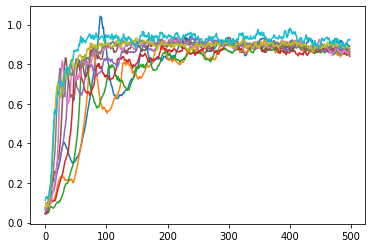

In [ ]:
plt.plot(A)

## Visualize the output

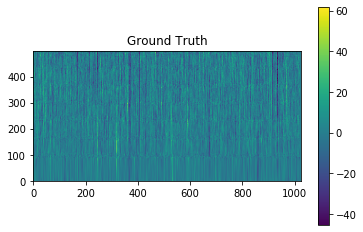

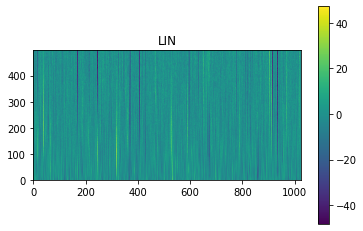

--------------------------------------------------------------------------------


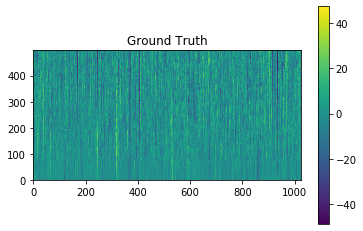

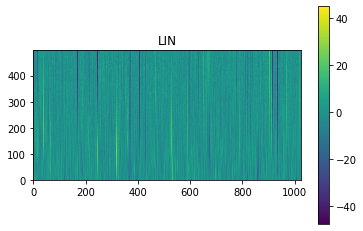

--------------------------------------------------------------------------------


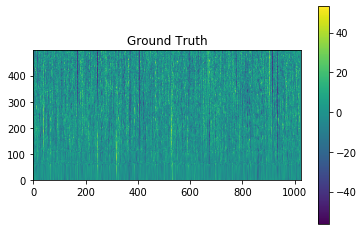

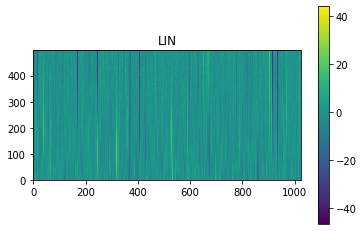

--------------------------------------------------------------------------------


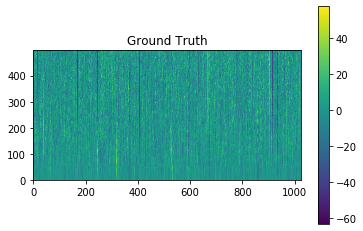

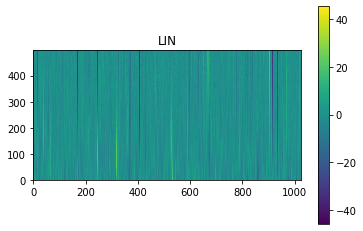

--------------------------------------------------------------------------------


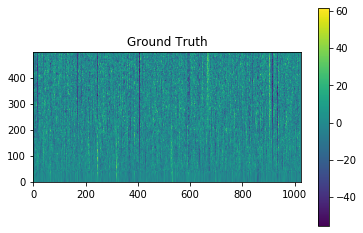

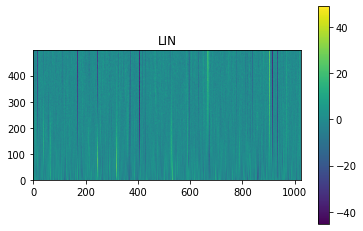

--------------------------------------------------------------------------------


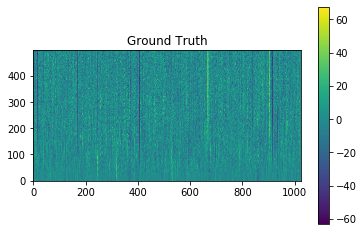

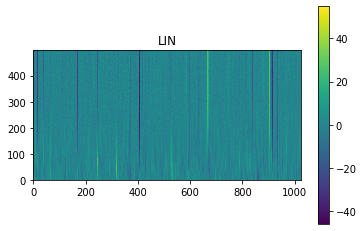

--------------------------------------------------------------------------------


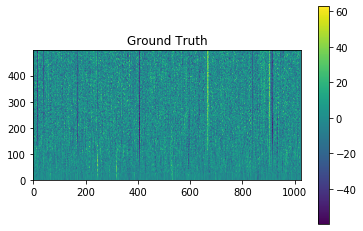

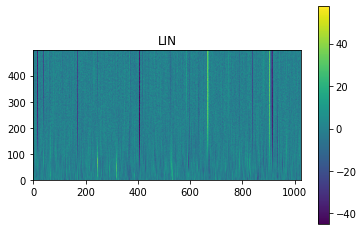

--------------------------------------------------------------------------------


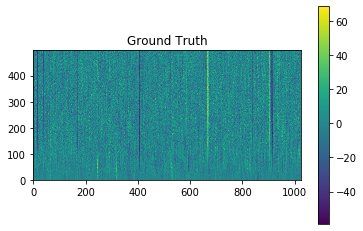

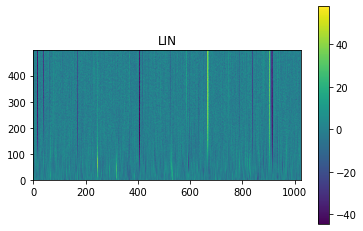

--------------------------------------------------------------------------------


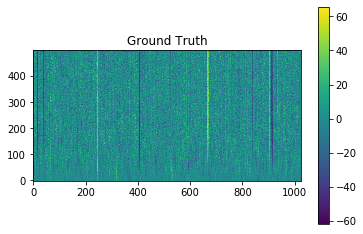

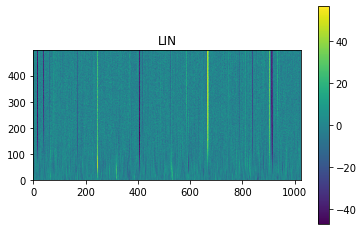

--------------------------------------------------------------------------------


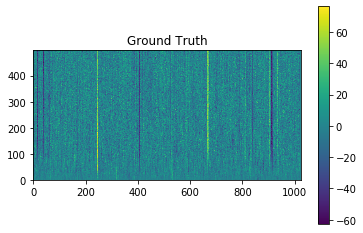

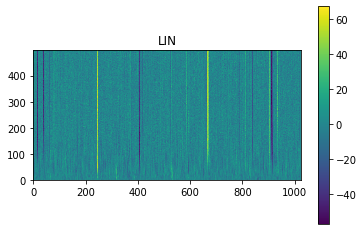

--------------------------------------------------------------------------------


In [ ]:
for test_ind in range(10):
    idx = test_ind # choose one of the test samples
    testDataset = LatentVectors(test_data[idx:idx+1],[testInletVelocities[idx]],doPreprocess=True,mx=x_mx,mn=x_mn)
    testDataLoader = DataLoader(dataset=testDataset, batch_size=1)
    X,y = next(iter(testDataLoader))
    X = X.to(device)

    y_hat = model(X)
    y_hat = y_hat.detach().cpu().numpy()[0]
    y = y.numpy()[0]
    
    y = invPreprocess(y.reshape(simLen-1,latentDim))
    y_hat = invPreprocess(y_hat.reshape(simLen-1,latentDim))
    plt.imshow(y,origin='lower')
    plt.colorbar()
    plt.title('Ground Truth')
    plt.show()
    plt.imshow(y_hat,origin='lower')
    plt.title('LIN')
    plt.colorbar()
    plt.show()
    print('-'*80)